### The tool reads in Measures Snowcover NetCdf downloaded from NSIDC. The tool then does a coordinate system transformation (from EASE Grid to WGS1984) and interpolates the specified snow cover variable. It returns a interpolated raster layer on ArcGIS Pro

<center><h3>Load Required R Modules that ingests NetCDF Files</h3></center>

In [9]:
library(raster)
library(sp)
library(rgdal)
library(tiff)
library(ncdf4)
library(chron)
library(lattice)
library(RColorBrewer)
library(gstat)

<center><h4>Reads in MEASURES NetCDF File</h4></center>

In [10]:
snowfile <- nc_open(file.choose())
snow_var <- "merged_snow_cover_extent"
snowfile

File C:\Users\lu9739\Documents\Projects\2019\January\MultidimWorkshop\nhtsw100e2_19800122_19800128_v01r01.nc (NC_FORMAT_NETCDF4_CLASSIC):

     6 variables (excluding dimension variables):
        float latitude[cols,rows]   
            _FillValue: -999
            long_name: latitude of cell center in EASE-Grid-2.0
            units: degrees_north
            valid_range: -90
             valid_range: 90
            standard_name: latitude
        float longitude[cols,rows]   
            _FillValue: -999
            long_name: longitude of cell center in EASE-Grid-2.0
            units: degrees_east
            valid_range: -180
             valid_range: 180
            standard_name: longitude
        byte merged_snow_cover_extent[cols,rows,time]   
            flag_meanings: cdr_microwave_report_snow cdr_only_reports_snow microwave_only_reports_snow snow_free_land permanent_ice ocean
            flag_values: 10
             flag_values: 11
             flag_values: 12
            

### Get longtitude and latitude, number of longitude and latitude values can be verified using the dim() function

In [11]:
longitude <- ncvar_get(snowfile,"longitude")
longitude <- longitude[!is.na(longitude)]

latitude <- ncvar_get(snowfile,"latitude")
latitude <- latitude[!is.na(latitude)]

GRID <- raster(res = c(0.10,0.10), xmn=-180, xmx=180, ymn=-90, ymx=90)

### Get the the snow cover product values and fill missing values (-99) with NA 

In [12]:
snow_array <- ncvar_get(snowfile,snow_var)
snow_array <- snow_array[!is.na(snow_array)]

fillvalue <- ncatt_get(snowfile,snow_var,"_FillValue")
dim(snow_array)

snow_array <- c(snow_array, na.rm = TRUE)
snow_array[snow_array==fillvalue$value] <- NA

NULL

In [13]:
fillvalue

$hasatt
[1] TRUE

$value
[1] -99

- Making the snow data frame, changing the coordinates, and limiting extent to northern hemisphere
- Making a snow dataframe (snow_df) containing lat/lon and the snow cover value
- Changing the coordinate system for the snow df from EASE-E to wgs-1984
- Crop the snow dataframe to show the Northern Hemisphere data

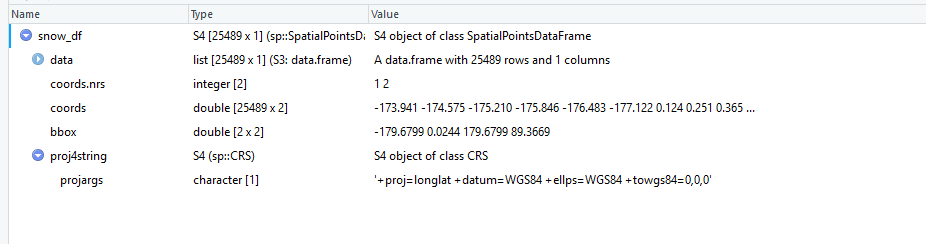

In [15]:

latitude <- c(latitude, na.rm = TRUE)

longtitude <- c(longitude, na.rm = TRUE)


#Changing the coordinate system from EASE-E to wgs-1984
snow_df <- data.frame(cbind(longitude, latitude,snow_array))
colnames(snow_df) <- c("Lon","Lat","Snow_Cover")
coordinates(snow_df) <- ~ Lon + Lat
snow_df@proj4string@projargs <- GRID@crs@projargs

Warning message in cbind(longitude, latitude, snow_array):
"number of rows of result is not a multiple of vector length (arg 1)"

###  Crop the snow dataframe to show the Northern Hemisphere points, then Interpolating Snow Cover Product as a Raster Dataset 

In [16]:
Snowcrop <- snow_df[which(coordinates(snow_df)[,1] > -180 & coordinates(snow_df)[,1] < 180),] #long
Snowcrop <- Snowcrop[which(coordinates(Snowcrop)[,2] > 0 & coordinates(Snowcrop)[,2] < 90),] #lat

### The Feature Dataset is now stored in a Spatial R Dataframe and ready to be Interpolated to produce a continous surface


Value Key:
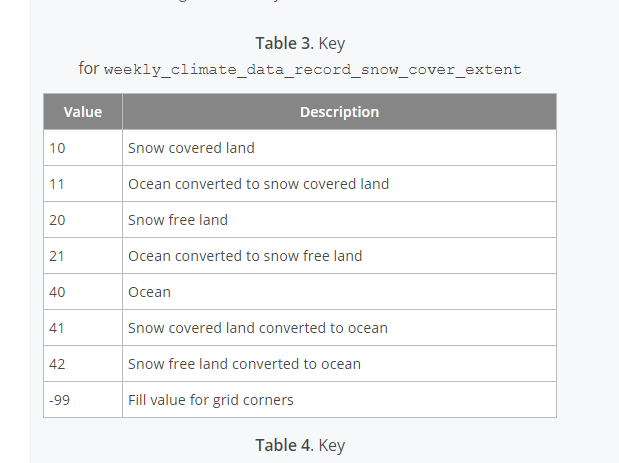

In [26]:
tail(Snowcrop@data[["Snow_Cover"]], 300)

[1] 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 [26] 20 20 20 20 20 20 20 20 20 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 [51] 40 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 [76] 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 40 40 40 40
[101] 40 40 40 40 40 40 40 40 40 40 40 40 20 20 20 20 20 20 20 20 20 20 20 20 40
[126] 40 40 40 40 40 40 40 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
[151] 20 20 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
[176] 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 20 20 20 20 20 20 20 20
[201] 20 20 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
[226] 40 40 40 40 40 40 40 40 40 40 40 40 40 20 20 20 20 20 20 40 40 40 40 40 40
[251] 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
[276] 40 20 20 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40  1 40

In [18]:
#Inverse Distance Weighted Interpolation ############################################################
GRIDcrop <- raster(res = c(2,2), xmn=-180, xmx=180, ymn=10, ymx=80)
GRIDcrop <- as(GRIDcrop, "SpatialGrid")
GRID <- as(GRID, "SpatialGrid")
Snowgrid <- idw(Snowcrop@data$Snow_Cover~1,location = Snowcrop, newdata=GRIDcrop, nmax = 6)
Snowgrid@data$var1.pred[which(Snowgrid@data$var1.pred < -1)] <- NA


[inverse distance weighted interpolation]


### Incorporate R Plotting Functionality by plotting the Sea Ice Data

Warning message in plot.window(...):
""interpolate" is not a graphical parameter"Warning message in plot.xy(xy, type, ...):
""interpolate" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""interpolate" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""interpolate" is not a graphical parameter"Warning message in box(...):
""interpolate" is not a graphical parameter"Warning message in title(...):
""interpolate" is not a graphical parameter"

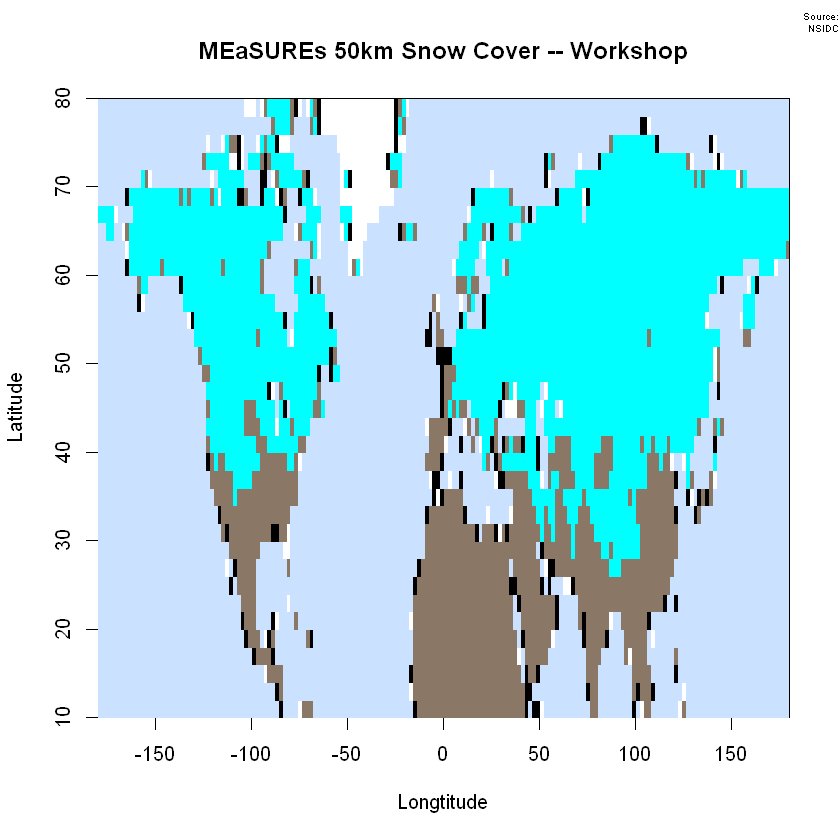

In [20]:
##Make a simple visualization
breakpoints <- c(13,21,35,50)
colors <- c("cyan","peachpuff4","black","white","lightsteelblue1")
image(raster(Snowgrid), col = colors,main="MEaSUREs 50km Snow Cover -- Workshop", 
 xlab="Longtitude", ylab="Latitude", interpolate = FALSE)
mtext('Source:\nNSIDC', side=3, line=-1.5, adj=T, outer=TRUE, cex = 0.5)


### Bridge Raster Data Into ArcGIS, using the R-ArcGIS Bridge


In [21]:
#####BridgeDataIntoR###############################################################
library(arcgisbinding)
arc.check_product()


arc.write("C:\\Users\\lu9739\\Documents\\ArcGIS\\Projects\\NSIDC_RBridge\\NSIDC_RBridge.gdb\\snow_extent_raster2", Snowgrid)

*** Please call arc.check_product() to define a desktop license.


product: ArcGIS Pro ( 12.4.0.19826 )
license: Advanced 
version: 1.0.1.232

ERROR: Error in .call_proxy("raster.create", .self, source, as.pairlist(args)): dataset already exists
